## Quick note about Jupyter cells

When you are editing a cell in Jupyter notebook, you need to re-run the cell by pressing `<Shift> + <Enter>`. This will allow changes you made to be available to other cells.

Use `<Enter>` to make new lines inside a cell you are editing.

### Code cells
Re-running will execute any statements you have written. To edit an existing code cell, click on it.

### Markdown cells
Re-running will render the markdown text. To edit an existing markdown cell, double-click on it.


### Common Jupyter operations

**Inserting and removing cells**

Use the "plus sign" icon to insert a cell below the currently selected cell
Use "Insert" -> "Insert Cell Above" from the menu to insert above

**Clear the output of all cells**

Use "Kernel" -> "Restart" from the menu to restart the kernel
click on "clear all outputs & restart" to have all the output cleared

**Show function signature**

Start typing function and hit `<Shift> + <Tab>`

# Preprocessing

## import necessary libraries

Import the following packages: `pandas as pd`, `csv`, `nltk` and `matplotlib.pyplot as plt`

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, hamming_loss, confusion_matrix
import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from conf_matrix import pplot_cm
import seaborn as sns

import pandas as pd
import csv
import nltk 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

## load data

As we have done the step of collecting some sample data for you already, you only have to load the data into a pandas dataframe using the method `pd.read_csv()`. Typing a variable name into a jupyter cell and running it, shows you the current content.

In [ ]:
#tweets = pd.read_csv('data/tweets/tweets.tsv', sep="\t")
tweets = pd.read_csv('data/tweets/examples.tsv', sep="\t", header = None)

In [ ]:
tweets.head()

,0,1,2,3,4
0,3123123123123,positive,hash1,[],Bin rundum begeistert. Insbesondere die Musikw...
1,123123123123123,negative,hash2,[],Startet leider nicht mehr. Ich hatte den Echo ...
2,123123123123,neutral,hash3,[],"Gut, aber im Alltag noch nicht ausgereift. Ama..."


In [ ]:
tweets.columns = ['ID','sentiment', 'hash', 'accessibly','text']

## inspect and clean data

The dataset contains several entries of messages that have been deleted by the user after posting them, use pandas' `str.contains()` or any other method like `loc` to remove all rows that represent a message not accessibly anymore ("Not Available").

In [ ]:
 ## TODO alle rows mit not available löschen
tweets_filtered = tweets[~tweets['text'].str.contains('Not Available')]

In [ ]:
tweets_filtered.head(2)

,ID,sentiment,hash,accessibly,text
0,3123123123123,positive,hash1,[],Bin rundum begeistert. Insbesondere die Musikw...
1,123123123123123,negative,hash2,[],Startet leider nicht mehr. Ich hatte den Echo ...


The columns we are most interested in are "text" and "sentiment". Use pandas' `groupby()` method in combination with `count()` to get a first notion about the distribution of our labels. 

Drop the rest of the columns to retain a dataframe with the two columns "text" and "sentiment".

Use the pandas function `str.replace()` to get rid of [twitter handles](https://www.urbandictionary.com/define.php?term=twitter%20handle) (hint: use regular expressions with `r'my_regex'` as the first argument `in str.replace()`).

**Advanced**
- Get rid of links. 
- Inspect the rest of the columns and keep some if they might contain information relevant to our prediction at a later stage.

<AxesSubplot:>

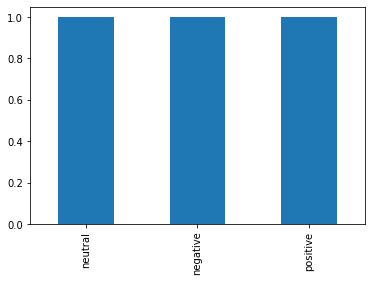

In [ ]:
tweets_filtered.sentiment.value_counts().plot.bar()

In [ ]:
tweets_basic = tweets_filtered.drop(["ID","hash","accessibly"],1)

In [ ]:
tweets_basic

,sentiment,text
0,positive,Bin rundum begeistert. Insbesondere die Musikw...
1,negative,Startet leider nicht mehr. Ich hatte den Echo ...
2,neutral,"Gut, aber im Alltag noch nicht ausgereift. Ama..."


In [ ]:
def light_clean_tweets(df):
    
    #To lowercase all characters
    df.loc[:,"text"] = df.text.apply(lambda x : str.lower(x))
  

    #To remove Links
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', "",x))    
    #To remove retweet RT:
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub('rt @\S+:', "",x))
    #To remove Mail addresses
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub(r'\S+@\S+', "",x))
    #To remove mentions
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub('@\S+', "",x))
    #To remove all characters except [a-zA-Z0-9_]
    #df.loc[:,"text"] = df.text.apply(lambda x : " ".join(re.findall(r'\w+',x)))
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub(r"([?.!,#])", r" \1 ", x))
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub(r'[" "]+', " ", x))
    # removing everything except (a-z, A-Z, ".", "?", "!", ",","#"," ")
    df.loc[:,"text"] = df.text.apply(lambda x : re.sub(r"[^a-zA-Z ]+", "", x))
    return(df)


In [ ]:
import re
tweets_basic = light_clean_tweets(tweets_basic)

In [ ]:
tweets_basic.head(2)

,sentiment,text
0,positive,bin rundum begeistert insbesondere die musikw...
1,negative,startet leider nicht mehr ich hatte den echo ...


## create single string to count word frequencies

In order to visualize word frequencies, we will concatenate all messages to create one long string containing all words present in these messages. 

Use `str.cat()` with `sep=' '` on the column 'text' to create one string containing all messages.

In [ ]:
merged_tweets = tweets_basic['text']

In [ ]:
merged_tweets = merged_tweets.str.cat(sep=' ')

In [ ]:
merged_tweets

'bin rundum begeistert  insbesondere die musikwiedergabe ist eine tolle sache  die bedienung lsst keine wnsche brig und ist kinderleicht  beste gre  max startet leider nicht mehr  ich hatte den echo leider nur ca   stunden einwandfrei in betrieb  danach ging er leider nicht mehr  kann mir vl jemand sagen wie ich ihn wieder zum laufen bringe oder ob er einfach nur kaputt ist   gut  aber im alltag noch nicht ausgereift  amazon echo ist eine praktische sache allerdings wenn man kein smarthome hat ist der einsatzbereich begrenzt  '

Pass merged_tweets to the `nltk` method `word_tokenize()` to create a list of tokens.

In [ ]:
merged_tweets_tokens = nltk.word_tokenize(merged_tweets)

In [ ]:
merged_tweets_tokens 


['bin',
 'rundum',
 'begeistert',
 'insbesondere',
 'die',
 'musikwiedergabe',
 'ist',
 'eine',
 'tolle',
 'sache',
 'die',
 'bedienung',
 'lsst',
 'keine',
 'wnsche',
 'brig',
 'und',
 'ist',
 'kinderleicht',
 'beste',
 'gre',
 'max',
 'startet',
 'leider',
 'nicht',
 'mehr',
 'ich',
 'hatte',
 'den',
 'echo',
 'leider',
 'nur',
 'ca',
 'stunden',
 'einwandfrei',
 'in',
 'betrieb',
 'danach',
 'ging',
 'er',
 'leider',
 'nicht',
 'mehr',
 'kann',
 'mir',
 'vl',
 'jemand',
 'sagen',
 'wie',
 'ich',
 'ihn',
 'wieder',
 'zum',
 'laufen',
 'bringe',
 'oder',
 'ob',
 'er',
 'einfach',
 'nur',
 'kaputt',
 'ist',
 'gut',
 'aber',
 'im',
 'alltag',
 'noch',
 'nicht',
 'ausgereift',
 'amazon',
 'echo',
 'ist',
 'eine',
 'praktische',
 'sache',
 'allerdings',
 'wenn',
 'man',
 'kein',
 'smarthome',
 'hat',
 'ist',
 'der',
 'einsatzbereich',
 'begrenzt']

We will use matplotlib to plot token frequencies. Set the matplotlib figure size to `(15, 8)` in order to create a larger plot area. 
Pass `merged_tweets_tokens` to `nltk.FreqDist()`, save the result as `fd` and call `fd.plot()` with `(50,cumulative=False)`.

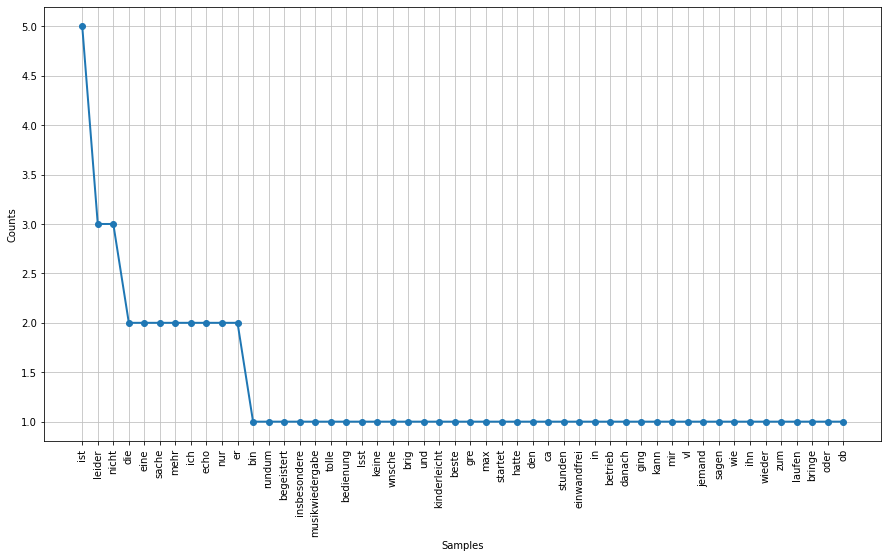

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [ ]:
# plot token frequencies
plt.figure(figsize=(15, 8))  
fd = nltk.FreqDist(merged_tweets_tokens)
fd.plot(50, cumulative=False, marker="o")

## save data

Use the pandas `to_csv()` method to save your dataframe as a .csv file. Name it "training_data_tweets.csv", set `encoding='utf-8'`, use `quoting=csv.QUOTE_ALL`, `header=False` and `index=False`.

In [ ]:
# save the dataframe in a format you can easily import in the following notebook
#tweets_basic.to_csv("training_data_tweets.csv", encoding="utf-8", quoting = csv.QUOTE_ALL, index = False)
tweets_basic.to_csv("examples_data_tweets.csv", encoding="utf-8", quoting = csv.QUOTE_ALL, index = False)


In [ ]:
tweets

,ID,sentiment,hash,accessibly,text
0,3123123123123,positive,hash1,[],Bin rundum begeistert. Insbesondere die Musikw...
1,123123123123123,negative,hash2,[],Startet leider nicht mehr. Ich hatte den Echo ...
2,123123123123,neutral,hash3,[],"Gut, aber im Alltag noch nicht ausgereift. Ama..."
